<a href="https://colab.research.google.com/github/LoPA607/SOC-2024/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np

In [ ]:
# prompt: mount drive and change directory

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SOC2024/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SOC2024


In [ ]:
!pwd



/content/drive/MyDrive/SOC2024


In [ ]:
! pip install einops


In [ ]:
# prompt: unzip data.zip to new dir data

!unzip render.zip -d data
!unzip text.zip -d data

Archive:  render.zip
replace data/render/20037.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  text.zip
replace data/celeba-caption/12839.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# @title diffusion utils
import pickle
import glob
import os
import torch


def load_latents(latent_path):
    r"""
    Simple utility to save latents to speed up ldm training
    :param latent_path:
    :return:
    """
    latent_maps = {}
    for fname in glob.glob(os.path.join(latent_path, '*.pkl')):
        s = pickle.load(open(fname, 'rb'))
        for k, v in s.items():
            latent_maps[k] = v[0]
    return latent_maps


def drop_text_condition(text_embed, im, empty_text_embed, text_drop_prob):
    if text_drop_prob > 0:
        text_drop_mask = torch.zeros((im.shape[0]), device=im.device).float().uniform_(0,
                                                                                       1) < text_drop_prob
        assert empty_text_embed is not None, ("Text Conditioning required as well as"
                                        " text dropping but empty text representation not created")
        text_embed[text_drop_mask, :, :] = empty_text_embed[0]
    return text_embed


def drop_image_condition(image_condition, im, im_drop_prob):
    if im_drop_prob > 0:
        im_drop_mask = torch.zeros((im.shape[0], 1, 1, 1), device=im.device).float().uniform_(0,
                                                                                        1) > im_drop_prob
        return image_condition * im_drop_mask
    else:
        return image_condition


def drop_class_condition(class_condition, class_drop_prob, im):
    if class_drop_prob > 0:
        class_drop_mask = torch.zeros((im.shape[0], 1), device=im.device).float().uniform_(0,
                                                                                           1) > class_drop_prob
        return class_condition * class_drop_mask
    else:
        return class_condition

In [ ]:
# @title text utils
import torch
from transformers import DistilBertModel, DistilBertTokenizer, CLIPTokenizer, CLIPTextModel


def get_tokenizer_and_model(model_type, device, eval_mode=True):
    assert model_type in ('bert', 'clip'), "Text model can only be one of clip or bert"
    if model_type == 'bert':
        text_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        text_model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)
    else:
        text_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch16')
        text_model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch16').to(device)
    if eval_mode:
        text_model.eval()
    return text_tokenizer, text_model


def get_text_representation(text, text_tokenizer, text_model, device,
                            truncation=True,
                            padding='max_length',
                            max_length=77):
    token_output = text_tokenizer(text,
                                  truncation=truncation,
                                  padding=padding,
                                  return_attention_mask=True,
                                  max_length=max_length)
    indexed_tokens = token_output['input_ids']
    att_masks = token_output['attention_mask']
    tokens_tensor = torch.tensor(indexed_tokens).to(device)
    mask_tensor = torch.tensor(att_masks).to(device)
    text_embed = text_model(tokens_tensor, attention_mask=mask_tensor).last_hidden_state
    return text_embed


In [ ]:
# @title config utils

def validate_class_config(condition_config):
    assert 'class_condition_config' in condition_config, \
        "Class conditioning desired but class condition config missing"
    assert 'num_classes' in condition_config['class_condition_config'], \
        "num_class missing in class condition config"


def validate_text_config(condition_config):
    assert 'text_condition_config' in condition_config, \
        "Text conditioning desired but text condition config missing"
    assert 'text_embed_dim' in condition_config['text_condition_config'], \
        "text_embed_dim missing in text condition config"


def validate_image_config(condition_config):
    assert 'image_condition_config' in condition_config, \
        "Image conditioning desired but image condition config missing"
    assert 'image_condition_input_channels' in condition_config['image_condition_config'], \
        "image_condition_input_channels missing in image condition config"
    assert 'image_condition_output_channels' in condition_config['image_condition_config'], \
        "image_condition_output_channels missing in image condition config"


def validate_image_conditional_input(cond_input, x):
    assert 'image' in cond_input, \
        "Model initialized with image conditioning but cond_input has no image information"
    assert cond_input['image'].shape[0] == x.shape[0], \
        "Batch size mismatch of image condition and input"
    assert cond_input['image'].shape[2] % x.shape[2] == 0, \
        "Height/Width of image condition must be divisible by latent input"


def validate_class_conditional_input(cond_input, x, num_classes):
    assert 'class' in cond_input, \
        "Model initialized with class conditioning but cond_input has no class information"
    assert cond_input['class'].shape == (x.shape[0], num_classes), \
        "Shape of class condition input must match (Batch Size, )"
def get_config_value(config, key, default_value):
    return config[key] if key in config else default_value

In [ ]:
# @title blocks
import torch
import torch.nn as nn


def get_time_embedding(time_steps, temb_dim):
    r"""
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula
    :param time_steps: 1D tensor of length batch size
    :param temb_dim: Dimension of the embedding
    :return: BxD embedding representation of B time steps
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"

    # factor = 10000^(2i/d_model)
    factor = 10000 ** ((torch.arange(
        start=0, end=temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    )

    # pos / factor
    # timesteps B -> B, 1 -> B, temb_dim
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample
    """

    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample, num_heads, num_layers, attn, norm_channels, cross_attn=False, context_dim=None):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(self.t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )

        if self.attn:
            self.attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )

            self.attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )

        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                 for _ in range(num_layers)]
            )

        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()

    def forward(self, x, t_emb=None, context=None):
        out = x
        for i in range(self.num_layers):
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            if self.attn:
                # Attention block of Unet
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn

            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn

        # Downsample
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """

    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads, num_layers, norm_channels, cross_attn=None, context_dim=None):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers + 1)
            ]
        )

        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers + 1)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers + 1)
            ]
        )

        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(norm_channels, out_channels)
             for _ in range(num_layers)]
        )

        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                 for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers + 1)
            ]
        )

    def forward(self, x, t_emb=None, context=None):
        out = x

        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)

        for i in range(self.num_layers):
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn


            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i + 1](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i + 1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i + 1](out)
            out = out + self.residual_input_conv[i + 1](resnet_input)

        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """

    def __init__(self, in_channels, out_channels, t_emb_dim,
                 up_sample, num_heads, num_layers, attn, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )

        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])

        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [
                    nn.GroupNorm(norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

            self.attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                    for _ in range(num_layers)
                ]
            )

        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels, in_channels,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()

    def forward(self, x, out_down=None, t_emb=None):
        # Upsample
        x = self.up_sample_conv(x)

        # Concat with Downblock output
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)

        out = x
        for i in range(self.num_layers):
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            # Self Attention
            if self.attn:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        return out


class UpBlockUnet(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """

    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample,
                 num_heads, num_layers, norm_channels, cross_attn=False, context_dim=None):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.cross_attn = cross_attn
        self.context_dim = context_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )

        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])

        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )

        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)
            ]
        )

        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )

        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                 for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()

    def forward(self, x, out_down=None, t_emb=None, context=None):
        x = self.up_sample_conv(x)
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)

        out = x
        for i in range(self.num_layers):
            # Resnet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            # Self Attention
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            # Cross Attention
            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert len(context.shape) == 3, \
                    "Context shape does not match B,_,CONTEXT_DIM"
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim,\
                    "Context shape does not match B,_,CONTEXT_DIM"
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn

        return out




In [ ]:



class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """

    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        # Mimicking how compvis repo creates schedule
        self.betas = (
                torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_timesteps) ** 2
        )
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)

    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)

        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)

    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the nosie predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)

        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)

            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

In [ ]:
import torch
from einops import einsum
import torch.nn as nn



class Unet(nn.Module):
    r"""
    Unet model comprising
    Down blocks, Midblocks and Uplocks
    """

    def __init__(self, im_channels, model_config):
        super().__init__()
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']
        self.attns = model_config['attn_down']
        self.norm_channels = model_config['norm_channels']
        self.num_heads = model_config['num_heads']
        self.conv_out_channels = model_config['conv_out_channels']

        # Validating Unet Model configurations
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1
        assert len(self.attns) == len(self.down_channels) - 1

        ######## Class, Mask and Text Conditioning Config #####
        self.class_cond = False
        self.text_cond = False
        self.image_cond = False
        self.text_embed_dim = None
        self.condition_config = get_config_value(model_config, 'condition_config', None)
        if self.condition_config is not None:
            assert 'condition_types' in self.condition_config, 'Condition Type not provided in model config'
            condition_types = self.condition_config['condition_types']
            if 'class' in condition_types:
                validate_class_config(self.condition_config)
                self.class_cond = True
                self.num_classes = self.condition_config['class_condition_config']['num_classes']
            if 'text' in condition_types:
                validate_text_config(self.condition_config)
                self.text_cond = True
                self.text_embed_dim = self.condition_config['text_condition_config']['text_embed_dim']
            if 'image' in condition_types:
                self.image_cond = True
                self.im_cond_input_ch = self.condition_config['image_condition_config'][
                    'image_condition_input_channels']
                self.im_cond_output_ch = self.condition_config['image_condition_config'][
                    'image_condition_output_channels']
        if self.class_cond:
            # Rather than using a special null class we dont add the
            # class embedding information for unconditional generation
            self.class_emb = nn.Embedding(self.num_classes,
                                          self.t_emb_dim)

        if self.image_cond:
            # Map the mask image to a N channel image and
            # concat that with input across channel dimension
            self.cond_conv_in = nn.Conv2d(in_channels=self.im_cond_input_ch,
                                          out_channels=self.im_cond_output_ch,
                                          kernel_size=1,
                                          bias=False)
            self.conv_in_concat = nn.Conv2d(im_channels + self.im_cond_output_ch,
                                            self.down_channels[0], kernel_size=3, padding=1)
        else:
            self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=1)
        self.cond = self.text_cond or self.image_cond or self.class_cond
        ###################################

        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.downs = nn.ModuleList([])

        # Build the Downblocks
        for i in range(len(self.down_channels) - 1):
            # Cross Attention and Context Dim only needed if text condition is present
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i + 1], self.t_emb_dim,
                                        down_sample=self.down_sample[i],
                                        num_heads=self.num_heads,
                                        num_layers=self.num_down_layers,
                                        attn=self.attns[i], norm_channels=self.norm_channels,
                                        cross_attn=self.text_cond,
                                        context_dim=self.text_embed_dim))

        self.mids = nn.ModuleList([])
        # Build the Midblocks
        for i in range(len(self.mid_channels) - 1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1], self.t_emb_dim,
                                      num_heads=self.num_heads,
                                      num_layers=self.num_mid_layers,
                                      norm_channels=self.norm_channels,
                                      cross_attn=self.text_cond,
                                      context_dim=self.text_embed_dim))

        self.ups = nn.ModuleList([])
        # Build the Upblocks
        for i in reversed(range(len(self.down_channels) - 1)):
            self.ups.append(
                UpBlockUnet(self.down_channels[i] * 2, self.down_channels[i - 1] if i != 0 else self.conv_out_channels,
                            self.t_emb_dim, up_sample=self.down_sample[i],
                            num_heads=self.num_heads,
                            num_layers=self.num_up_layers,
                            norm_channels=self.norm_channels,
                            cross_attn=self.text_cond,
                            context_dim=self.text_embed_dim))

        self.norm_out = nn.GroupNorm(self.norm_channels, self.conv_out_channels)
        self.conv_out = nn.Conv2d(self.conv_out_channels, im_channels, kernel_size=3, padding=1)

    def forward(self, x, t, cond_input=None):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        if self.cond:
            assert cond_input is not None, \
                "Model initialized with conditioning so cond_input cannot be None"
        if self.image_cond:
            ######## Mask Conditioning ########
            validate_image_conditional_input(cond_input, x)
            im_cond = cond_input['image']
            im_cond = torch.nn.functional.interpolate(im_cond, size=x.shape[-2:])
            im_cond = self.cond_conv_in(im_cond)
            assert im_cond.shape[-2:] == x.shape[-2:]
            x = torch.cat([x, im_cond], dim=1)
            # B x (C+N) x H x W
            out = self.conv_in_concat(x)
            #####################################
        else:
            # B x C x H x W
            out = self.conv_in(x)
        # B x C1 x H x W

        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        ######## Class Conditioning ########
        if self.class_cond:
            validate_class_conditional_input(cond_input, x, self.num_classes)
            class_embed = einsum(cond_input['class'].float(), self.class_emb.weight, 'b n, n d -> b d')
            t_emb += class_embed
        ####################################

        context_hidden_states = None
        if self.text_cond:
            assert 'text' in cond_input, \
                "Model initialized with text conditioning but cond_input has no text information"
            context_hidden_states = cond_input['text']
        down_outs = []

        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb, context_hidden_states)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4

        for mid in self.mids:
            out = mid(out, t_emb, context_hidden_states)
        # out B x C3 x H/4 x W/4

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb, context_hidden_states)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out

In [ ]:
import torch
import torch.nn as nn



class VQVAE(nn.Module):
    def __init__(self, im_channels, model_config):
        super().__init__()
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']

        # To disable attention in Downblock of Encoder and Upblock of Decoder
        self.attns = model_config['attn_down']

        # Latent Dimension
        self.z_channels = model_config['z_channels']
        self.codebook_size = model_config['codebook_size']
        self.norm_channels = model_config['norm_channels']
        self.num_heads = model_config['num_heads']

        # Assertion to validate the channel information
        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-1]
        assert len(self.down_sample) == len(self.down_channels) - 1
        assert len(self.attns) == len(self.down_channels) - 1

        # Wherever we use downsampling in encoder correspondingly use
        # upsampling in decoder
        self.up_sample = list(reversed(self.down_sample))

        ##################### Encoder ######################
        self.encoder_conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))

        # Downblock + Midblock
        self.encoder_layers = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.encoder_layers.append(DownBlock(self.down_channels[i], self.down_channels[i + 1],
                                                 t_emb_dim=None, down_sample=self.down_sample[i],
                                                 num_heads=self.num_heads,
                                                 num_layers=self.num_down_layers,
                                                 attn=self.attns[i],
                                                 norm_channels=self.norm_channels))

        self.encoder_mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.encoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))

        self.encoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[-1])
        self.encoder_conv_out = nn.Conv2d(self.down_channels[-1], self.z_channels, kernel_size=3, padding=1)

        # Pre Quantization Convolution
        self.pre_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)

        # Codebook
        self.embedding = nn.Embedding(self.codebook_size, self.z_channels)
        ####################################################

        ##################### Decoder ######################

        # Post Quantization Convolution
        self.post_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        self.decoder_conv_in = nn.Conv2d(self.z_channels, self.mid_channels[-1], kernel_size=3, padding=(1, 1))

        # Midblock + Upblock
        self.decoder_mids = nn.ModuleList([])
        for i in reversed(range(1, len(self.mid_channels))):
            self.decoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i - 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))

        self.decoder_layers = nn.ModuleList([])
        for i in reversed(range(1, len(self.down_channels))):
            self.decoder_layers.append(UpBlock(self.down_channels[i], self.down_channels[i - 1],
                                               t_emb_dim=None, up_sample=self.down_sample[i - 1],
                                               num_heads=self.num_heads,
                                               num_layers=self.num_up_layers,
                                               attn=self.attns[i-1],
                                               norm_channels=self.norm_channels))

        self.decoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[0])
        self.decoder_conv_out = nn.Conv2d(self.down_channels[0], im_channels, kernel_size=3, padding=1)

    def quantize(self, x):
        B, C, H, W = x.shape

        # B, C, H, W -> B, H, W, C
        x = x.permute(0, 2, 3, 1)

        # B, H, W, C -> B, H*W, C
        x = x.reshape(x.size(0), -1, x.size(-1))

        # Find nearest embedding/codebook vector
        # dist between (B, H*W, C) and (B, K, C) -> (B, H*W, K)
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        # (B, H*W)
        min_encoding_indices = torch.argmin(dist, dim=-1)

        # Replace encoder output with nearest codebook
        # quant_out -> B*H*W, C
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))

        # x -> B*H*W, C
        x = x.reshape((-1, x.size(-1)))
        commmitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {
            'codebook_loss': codebook_loss,
            'commitment_loss': commmitment_loss
        }
        # Straight through estimation
        quant_out = x + (quant_out - x).detach()

        # quant_out -> B, C, H, W
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        return quant_out, quantize_losses, min_encoding_indices

    def encode(self, x):
        out = self.encoder_conv_in(x)
        for idx, down in enumerate(self.encoder_layers):
            out = down(out)
        for mid in self.encoder_mids:
            out = mid(out)
        out = self.encoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.encoder_conv_out(out)
        out = self.pre_quant_conv(out)
        out, quant_losses, _ = self.quantize(out)
        return out, quant_losses

    def decode(self, z):
        out = z
        out = self.post_quant_conv(out)
        out = self.decoder_conv_in(out)
        for mid in self.decoder_mids:
            out = mid(out)
        for idx, up in enumerate(self.decoder_layers):
            out = up(out)

        out = self.decoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.decoder_conv_out(out)
        return out

    def forward(self, x):
        z, quant_losses = self.encode(x)
        out = self.decode(z)
        return out, z, quant_losses


In [ ]:
# @title discriminator
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    r"""
    PatchGAN Discriminator.
    Rather than taking IMG_CHANNELSxIMG_HxIMG_W all the way to
    1 scalar value , we instead predict grid of values.
    Where each grid is prediction of how likely
    the discriminator thinks that the image patch corresponding
    to the grid cell is real
    """

    def __init__(self, im_channels=3,
                 conv_channels=[64, 128, 256],
                 kernels=[4,4,4,4],
                 strides=[2,2,2,1],
                 paddings=[1,1,1,1]):
        super().__init__()
        self.im_channels = im_channels
        activation = nn.LeakyReLU(0.2)
        layers_dim = [self.im_channels] + conv_channels + [1]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(layers_dim[i], layers_dim[i + 1],
                          kernel_size=kernels[i],
                          stride=strides[i],
                          padding=paddings[i],
                          bias=False if i !=0 else True),
                nn.BatchNorm2d(layers_dim[i + 1]) if i != len(layers_dim) - 2 and i != 0 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Identity()
            )
            for i in range(len(layers_dim) - 1)
        ])

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out


if __name__ == '__main__':
    x = torch.randn((2,3, 256, 256))
    prob = Discriminator(im_channels=3)(x)
    print(prob.shape)

torch.Size([2, 1, 31, 31])


In [ ]:
# @title LPIPS
from __future__ import absolute_import
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
import torch.nn
import torchvision

# Taken from https://github.com/richzhang/PerceptualSimilarity/blob/master/lpips/lpips.py

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def spatial_average(in_tens, keepdim=True):
    return in_tens.mean([2, 3], keepdim=keepdim)


class vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(vgg16, self).__init__()
        # Load pretrained vgg model from torchvision
        vgg_pretrained_features = torchvision.models.vgg16(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])

        # Freeze vgg model
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        # Return output of vgg features
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)
        return out


# Learned perceptual metric
class LPIPS(nn.Module):
    def __init__(self, net='vgg', version='0.1', use_dropout=True):
        super(LPIPS, self).__init__()
        self.version = version
        # Imagenet normalization
        self.scaling_layer = ScalingLayer()
        ########################

        # Instantiate vgg model
        self.chns = [64, 128, 256, 512, 512]
        self.L = len(self.chns)
        self.net = vgg16(pretrained=True, requires_grad=False)

        # Add 1x1 convolutional Layers
        self.lin0 = NetLinLayer(self.chns[0], use_dropout=use_dropout)
        self.lin1 = NetLinLayer(self.chns[1], use_dropout=use_dropout)
        self.lin2 = NetLinLayer(self.chns[2], use_dropout=use_dropout)
        self.lin3 = NetLinLayer(self.chns[3], use_dropout=use_dropout)
        self.lin4 = NetLinLayer(self.chns[4], use_dropout=use_dropout)
        self.lins = [self.lin0, self.lin1, self.lin2, self.lin3, self.lin4]
        self.lins = nn.ModuleList(self.lins)
        ########################

        # Load the weights of trained LPIPS model
        import inspect
        import os
        model_path = os.path.abspath(
            os.path.join(inspect.getfile(self.__init__), '..', 'weights/v%s/%s.pth' % (version, net)))
        print('Loading model from: %s' % model_path)
        self.load_state_dict(torch.load(model_path, map_location=device), strict=False)
        ########################

        # Freeze all parameters
        self.eval()
        for param in self.parameters():
            param.requires_grad = False
        ########################

    def forward(self, in0, in1, normalize=False):
        # Scale the inputs to -1 to +1 range if needed
        if normalize:  # turn on this flag if input is [0,1] so it can be adjusted to [-1, +1]
            in0 = 2 * in0 - 1
            in1 = 2 * in1 - 1
        ########################

        # Normalize the inputs according to imagenet normalization
        in0_input, in1_input = self.scaling_layer(in0), self.scaling_layer(in1)
        ########################

        # Get VGG outputs for image0 and image1
        outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
        feats0, feats1, diffs = {}, {}, {}
        ########################

        # Compute Square of Difference for each layer output
        for kk in range(self.L):
            feats0[kk], feats1[kk] = torch.nn.functional.normalize(outs0[kk], dim=1), torch.nn.functional.normalize(
                outs1[kk])
            diffs[kk] = (feats0[kk] - feats1[kk]) ** 2
        ########################

        # 1x1 convolution followed by spatial average on the square differences
        res = [spatial_average(self.lins[kk](diffs[kk]), keepdim=True) for kk in range(self.L)]
        val = 0

        # Aggregate the results of each layer
        for l in range(self.L):
            val += res[l]
        return val


class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        # Imagnet normalization for (0-1)
        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]
        self.register_buffer('shift', torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer('scale', torch.Tensor([.458, .448, .450])[None, :, None, None])

    def forward(self, inp):
        return (inp - self.shift) / self.scale


class NetLinLayer(nn.Module):
    ''' A single linear layer which does a 1x1 conv '''

    def __init__(self, chn_in, chn_out=1, use_dropout=False):
        super(NetLinLayer, self).__init__()

        layers = [nn.Dropout(), ] if (use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, 1, stride=1, padding=0, bias=False), ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

In [ ]:
import yaml
import argparse
import torch
import random
import torchvision
import os
import numpy as np
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train(args):
    # Read the config file #
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)

    dataset_config = config['dataset_params']
    autoencoder_config = config['autoencoder_params']
    train_config = config['train_params']

    # Set the desired seed value #
    seed = train_config['seed']
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if device == 'cuda':
        torch.cuda.manual_seed_all(seed)
    #############################

    # Create the model and dataset #
    model = VQVAE(im_channels=dataset_config['im_channels'],
                  model_config=autoencoder_config).to(device)
    # Create the dataset
    im_dataset_cls = {
        'celebhq': CelebDataset,
    }.get(dataset_config['name'])

    im_dataset = im_dataset_cls(split='train',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'])

    data_loader = DataLoader(im_dataset,
                             batch_size=train_config['autoencoder_batch_size'],
                             shuffle=True)

    # Create output directories
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])

    num_epochs = train_config['autoencoder_epochs']

    # L1/L2 loss for Reconstruction
    recon_criterion = torch.nn.MSELoss()
    # Disc Loss can even be BCEWithLogits
    disc_criterion = torch.nn.MSELoss()

    # No need to freeze lpips as lpips.py takes care of that
    lpips_model = LPIPS().eval().to(device)
    discriminator = Discriminator(im_channels=dataset_config['im_channels']).to(device)

    optimizer_d = Adam(discriminator.parameters(), lr=train_config['autoencoder_lr'], betas=(0.5, 0.999))
    optimizer_g = Adam(model.parameters(), lr=train_config['autoencoder_lr'], betas=(0.5, 0.999))

    disc_step_start = train_config['disc_start']
    step_count = 0

    # This is for accumulating gradients incase the images are huge
    # And one cant afford higher batch sizes
    acc_steps = train_config['autoencoder_acc_steps']
    image_save_steps = train_config['autoencoder_img_save_steps']
    img_save_count = 0

    for epoch_idx in range(num_epochs):
        recon_losses = []
        codebook_losses = []
        #commitment_losses = []
        perceptual_losses = []
        disc_losses = []
        gen_losses = []
        losses = []

        optimizer_g.zero_grad()
        optimizer_d.zero_grad()

        for im in tqdm(data_loader):
            step_count += 1
            im = im.float().to(device)

            # Fetch autoencoders output(reconstructions)
            model_output = model(im)
            output, z, quantize_losses = model_output

            # Image Saving Logic
            if step_count % image_save_steps == 0 or step_count == 1:
                sample_size = min(8, im.shape[0])
                save_output = torch.clamp(output[:sample_size], -1., 1.).detach().cpu()
                save_output = ((save_output + 1) / 2)
                save_input = ((im[:sample_size] + 1) / 2).detach().cpu()

                grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)
                img = torchvision.transforms.ToPILImage()(grid)
                if not os.path.exists(os.path.join(train_config['task_name'],'vqvae_autoencoder_samples')):
                    os.mkdir(os.path.join(train_config['task_name'], 'vqvae_autoencoder_samples'))
                img.save(os.path.join(train_config['task_name'],'vqvae_autoencoder_samples',
                                      'current_autoencoder_sample_{}.png'.format(img_save_count)))
                img_save_count += 1
                img.close()

            ######### Optimize Generator ##########
            # L2 Loss
            recon_loss = recon_criterion(output, im)
            recon_losses.append(recon_loss.item())
            recon_loss = recon_loss / acc_steps
            g_loss = (recon_loss +
                      (train_config['codebook_weight'] * quantize_losses['codebook_loss'] / acc_steps) +
                      (train_config['commitment_beta'] * quantize_losses['commitment_loss'] / acc_steps))
            codebook_losses.append(train_config['codebook_weight'] * quantize_losses['codebook_loss'].item())
            # Adversarial loss only if disc_step_start steps passed
            if step_count > disc_step_start:
                disc_fake_pred = discriminator(model_output[0])
                disc_fake_loss = disc_criterion(disc_fake_pred,
                                                torch.ones(disc_fake_pred.shape,
                                                           device=disc_fake_pred.device))
                gen_losses.append(train_config['disc_weight'] * disc_fake_loss.item())
                g_loss += train_config['disc_weight'] * disc_fake_loss / acc_steps
            lpips_loss = torch.mean(lpips_model(output, im)) / acc_steps
            perceptual_losses.append(train_config['perceptual_weight'] * lpips_loss.item())
            g_loss += train_config['perceptual_weight']*lpips_loss / acc_steps
            losses.append(g_loss.item())
            g_loss.backward()
            #####################################

            ######### Optimize Discriminator #######
            if step_count > disc_step_start:
                fake = output
                disc_fake_pred = discriminator(fake.detach())
                disc_real_pred = discriminator(im)
                disc_fake_loss = disc_criterion(disc_fake_pred,
                                                torch.zeros(disc_fake_pred.shape,
                                                            device=disc_fake_pred.device))
                disc_real_loss = disc_criterion(disc_real_pred,
                                                torch.ones(disc_real_pred.shape,
                                                           device=disc_real_pred.device))
                disc_loss = train_config['disc_weight'] * (disc_fake_loss + disc_real_loss) / 2
                disc_losses.append(disc_loss.item())
                disc_loss = disc_loss / acc_steps
                disc_loss.backward()
                if step_count % acc_steps == 0:
                    optimizer_d.step()
                    optimizer_d.zero_grad()
            #####################################

            if step_count % acc_steps == 0:
                optimizer_g.step()
                optimizer_g.zero_grad()
        optimizer_d.step()
        optimizer_d.zero_grad()
        optimizer_g.step()
        optimizer_g.zero_grad()
        if len(disc_losses) > 0:
            print(
                'Finished epoch: {} | Recon Loss : {:.4f} | Perceptual Loss : {:.4f} | '
                'Codebook : {:.4f} | G Loss : {:.4f} | D Loss {:.4f}'.
                format(epoch_idx + 1,
                       np.mean(recon_losses),
                       np.mean(perceptual_losses),
                       np.mean(codebook_losses),
                       np.mean(gen_losses),
                       np.mean(disc_losses)))
        else:
            print('Finished epoch: {} | Recon Loss : {:.4f} | Perceptual Loss : {:.4f} | Codebook : {:.4f}'.
                  format(epoch_idx + 1,
                         np.mean(recon_losses),
                         np.mean(perceptual_losses),
                         np.mean(codebook_losses)))

        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['vqvae_autoencoder_ckpt_name']))
        torch.save(discriminator.state_dict(), os.path.join(train_config['task_name'],
                                                            train_config['vqvae_discriminator_ckpt_name']))
    print('Done Training...')


if __name__ == '__main__':
    #parser = argparse.ArgumentParser(description='Arguments for vq vae training')
    #parser.add_argument('--config', dest='config_path',
                        #default='/content/celebhq_text_image_cond.yaml', type=str,
                       # help='Path to the configuration file') # Add a help message for clarity

    args = argparse.Namespace(config_path='/content/drive/MyDrive/SOC2024/celebhq_text_image_cond.yaml')
    train(args)

{'dataset_params': {'im_path': 'data/render', 'im_channels': 3, 'im_size': 256, 'name': 'celebhq'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.00085, 'beta_end': 0.012}, 'ldm_params': {'down_channels': [256, 384, 512, 768], 'mid_channels': [768, 512], 'down_sample': [True, True, True], 'attn_down': [True, True, True], 'time_emb_dim': 512, 'norm_channels': 32, 'num_heads': 16, 'conv_out_channels': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'condition_config': {'condition_types': ['text', 'image'], 'text_condition_config': {'text_embed_model': 'clip', 'train_text_embed_model': False, 'text_embed_dim': 512, 'cond_drop_prob': 0.1}, 'image_condition_config': {'image_condition_input_channels': 18, 'image_condition_output_channels': 3, 'image_condition_h': 512, 'image_condition_w': 512, 'cond_drop_prob': 0.1}}}, 'autoencoder_params': {'z_channels': 3, 'codebook_size': 8192, 'down_channels': [64, 128, 256, 256], 'mid_channels': [256, 256], 'down_sample

100%|██████████| 29437/29437 [00:00<00:00, 513281.15it/s]

Found 29437 images
Found 0 captions



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /content/drive/MyDrive/SOC2024/weights/v0.1/vgg.pth


  1%|          | 74/7360 [01:08<1:59:46,  1.01it/s]

In [ ]:
import glob
import os
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch.utils.data.dataset import Dataset


class CelebDataset(Dataset):
    r"""
    Celeb dataset will by default centre crop and resize the images.
    This can be replaced by any other dataset. As long as all the images
    are under one directory.
    """

    def __init__(self, split, im_path='/content/data/render/', im_size=256, im_channels=3, im_ext='png',
                 use_latents=False, latent_path=None, condition_config=None):
        self.split = split
        self.im_size = im_size
        self.im_channels = im_channels
        self.im_ext = im_ext
        self.im_path = im_path
        self.latent_maps = None
        self.use_latents = None

        self.condition_types = [] if condition_config is None else condition_config['condition_types']

        self.idx_to_cls_map = {}
        self.cls_to_idx_map ={}

        if 'image' in self.condition_types:
            self.mask_channels = condition_config['image_condition_config']['image_condition_input_channels']
            self.mask_h = condition_config['image_condition_config']['image_condition_h']
            self.mask_w = condition_config['image_condition_config']['image_condition_w']
        print("Image path:",im_path)
        self.images, self.texts= self.load_images(im_path)

        # Whether to load images or to load latents
        if use_latents and latent_path is not None:
            latent_maps = []
            if len(latent_maps) == len(self.images):
                self.use_latents = True
                self.latent_maps = latent_maps
                print('Found {} latents'.format(len(self.latent_maps)))
            else:
                print('Latents not found')


    def load_images(self,im_path): # Removed 'self'
        """
        Gets all images from the path specified and stacks them all up.
        """
        assert os.path.exists(im_path), f"Images path {im_path} does not exist"

        # Use glob to find PNG files
        ims=[]
        texts=[]
        condition_types = self.condition_types
        fnames = glob.glob(os.path.join(im_path, f'*.{self.im_ext}'))
        print(f'Found {len(fnames)} images')

        if 'image' in condition_types: # Access condition_types directly
            label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth',
                          'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
            self.idx_to_cls_map = {idx: label_list[idx] for idx in range(len(label_list))} # Removed 'self.'
            self.cls_to_idx_map = {label_list[idx]: idx for idx in range(len(label_list))} # Removed 'self.'

        for fname in tqdm(fnames):
            ims.append(fname)

            if 'text' in condition_types: # Access condition_types directly
                im_name = os.path.splitext(os.path.basename(fname))[0]
                caption_path = os.path.join('/content/data/celeba-caption/', f'{im_name}.txt')
                if os.path.exists(caption_path):
                    with open(caption_path) as f:
                        captions_im = [line.strip() for line in f.readlines()]
                    texts.append(captions_im)
                else:
                    print(f"Caption file missing for image: {fname}")

        if 'text' in condition_types: # Access condition_types directly
            assert len(texts) == len(ims), "Condition Type Text but could not find captions for all images"

        print(f'Found {len(ims)} images')
        print(f'Found {len(texts)} captions')

        return ims, texts


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        ######## Set Conditioning Info ########
        if 'text' in self.condition_types:
            {}['text'] = random.sample(self.texts[index], k=1)[0]
        if 'image' in self.condition_types:
            mask = self.get_mask(index)
            {}['image'] = mask
        #######################################

        if self.use_latents:
            latent = self.latent_maps[self.images[index]]
            if len(self.condition_types) == 0:
                return latent
            else:
                return latent, {}
        else:
            im = Image.open(self.images[index])
            im_tensor = torchvision.transforms.Compose([
                torchvision.transforms.Resize(self.im_size),
                torchvision.transforms.CenterCrop(self.im_size),
                torchvision.transforms.ToTensor(),
            ])(im)
            im.close()

            # Convert input to -1 to 1 range.
            im_tensor = (2 * im_tensor) - 1
            if len(self.condition_types) == 0:
                return im_tensor
            else:
                return im_tensor, {}


In [ ]:
import yaml
import argparse
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train(args):
    # Read the config file #
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    ########################

    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    diffusion_model_config = config['ldm_params']
    autoencoder_model_config = config['autoencoder_params']
    train_config = config['train_params']

    ########## Create the noise scheduler #############
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
    ###############################################

    # Instantiate Condition related components
    text_tokenizer = None
    text_model = None
    empty_text_embed = None
    condition_types = []
    condition_config = get_config_value(diffusion_model_config, key='condition_config', default_value=None)
    if condition_config is not None:
        assert 'condition_types' in condition_config, \
            "condition type missing in conditioning config"
        condition_types = condition_config['condition_types']
        if 'text' in condition_types:
            validate_text_config(condition_config)
            with torch.no_grad():
                # Load tokenizer and text model based on config
                # Also get empty text representation
                text_tokenizer, text_model = get_tokenizer_and_model(condition_config['text_condition_config']
                                                                     ['text_embed_model'], device=device)
                empty_text_embed = get_text_representation([''], text_tokenizer, text_model, device)

    im_dataset_cls = {
        'celebhq': CelebDataset,
    }.get(dataset_config['name'])

    im_dataset = im_dataset_cls(split='train',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'],
                                use_latents=True,
                                latent_path=os.path.join(train_config['task_name'],
                                                         train_config['vqvae_latent_dir_name']),
                                condition_config=condition_config)


    data_loader = DataLoader(im_dataset,
                             batch_size=train_config['ldm_batch_size'],
                             shuffle=True)

    # Instantiate the unet model
    model = Unet(im_channels=autoencoder_model_config['z_channels'],
                 model_config=diffusion_model_config).to(device)
    model.train()

    vae = None
    # Load VAE ONLY if latents are not to be saved or some are missing
    if not im_dataset.use_latents:
        print('Loading vqvae model as latents not present')
        vae = VQVAE(im_channels=dataset_config['im_channels'],
                    model_config=autoencoder_model_config).to(device)
        vae.eval()
        # Load vae if found
        if os.path.exists(os.path.join(train_config['task_name'],
                                       train_config['vqvae_autoencoder_ckpt_name'])):
            print('Loaded vae checkpoint')
            vae.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                        train_config['vqvae_autoencoder_ckpt_name']),
                                           map_location=device))
        else:
            raise Exception('VAE checkpoint not found and use_latents was disabled')

    # Specify training parameters
    num_epochs = train_config['ldm_epochs']
    optimizer = Adam(model.parameters(), lr=train_config['ldm_lr'])
    criterion = torch.nn.MSELoss()

    # Load vae and freeze parameters ONLY if latents already not saved
    if not im_dataset.use_latents:
        assert vae is not None
        for param in vae.parameters():
            param.requires_grad = False

    # Run training
    for epoch_idx in range(num_epochs):
        losses = []
        for data in tqdm(data_loader):
            cond_input = None
            if condition_config is not None:
                im, cond_input = data
            else:
                im = data
            optimizer.zero_grad()
            im = im.float().to(device)
            if not im_dataset.use_latents:
                with torch.no_grad():
                    im, _ = vae.encode(im)

            ########### Handling Conditional Input ###########
            if 'text' in condition_types:
                with torch.no_grad():
                    assert 'text' in cond_input, 'Conditioning Type Text but no text conditioning input present'
                    validate_text_config(condition_config)
                    text_condition = get_text_representation(cond_input['text'],
                                                                 text_tokenizer,
                                                                 text_model,
                                                                 device)
                    text_drop_prob = get_config_value(condition_config['text_condition_config'],
                                                      'cond_drop_prob', 0.)
                    text_condition = drop_text_condition(text_condition, im, empty_text_embed, text_drop_prob)
                    cond_input['text'] = text_condition
            if 'image' in condition_types:
                assert 'image' in cond_input, 'Conditioning Type Image but no image conditioning input present'
                validate_image_config(condition_config)
                cond_input_image = cond_input['image'].to(device)
                # Drop condition
                im_drop_prob = get_config_value(condition_config['image_condition_config'],
                                                      'cond_drop_prob', 0.)
                cond_input['image'] = drop_image_condition(cond_input_image, im, im_drop_prob)
            if 'class' in condition_types:
                assert 'class' in cond_input, 'Conditioning Type Class but no class conditioning input present'
                validate_class_config(condition_config)
                class_condition = torch.nn.functional.one_hot(
                    cond_input['class'],
                    condition_config['class_condition_config']['num_classes']).to(device)
                class_drop_prob = get_config_value(condition_config['class_condition_config'],
                                                   'cond_drop_prob', 0.)
                # Drop condition
                cond_input['class'] = drop_class_condition(class_condition, class_drop_prob, im)
            ################################################

            # Sample random noise
            noise = torch.randn_like(im).to(device)

            # Sample timestep
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)

            # Add noise to images according to timestep
            noisy_im = scheduler.add_noise(im, noise, t)
            noise_pred = model(noisy_im, t, cond_input=cond_input)
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print('Finished epoch:{} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(losses)))
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['ldm_ckpt_name']))

    print('Done Training ...')


if __name__ == '__main__':
    #parser = argparse.ArgumentParser(description='Arguments for ddpm training')
    #parser.add_argument('--config_path', dest='config_path',
                        #default='content/celebhq_text_cond_clip.yaml', type=str)
    #args = parser.parse_args()
    args = argparse.Namespace(config_path='/content/celebhq_text_image_cond.yaml')
    train(args)

In [ ]:
import yaml
import argparse
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train(args):
    # Read the config file #
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)
    ########################

    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    diffusion_model_config = config['ldm_params']
    autoencoder_model_config = config['autoencoder_params']
    train_config = config['train_params']

    ########## Create the noise scheduler #############
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
    ###############################################

    # Instantiate Condition related components
    text_tokenizer = None
    text_model = None
    empty_text_embed = None
    condition_types = []
    condition_config = get_config_value(diffusion_model_config, key='condition_config', default_value=None)
    if condition_config is not None:
        assert 'condition_types' in condition_config, \
            "condition type missing in conditioning config"
        condition_types = condition_config['condition_types']
        if 'text' in condition_types:
            validate_text_config(condition_config)
            with torch.no_grad():
                # Load tokenizer and text model based on config
                # Also get empty text representation
                text_tokenizer, text_model = get_tokenizer_and_model(condition_config['text_condition_config']
                                                                     ['text_embed_model'], device=device)
                empty_text_embed = get_text_representation([''], text_tokenizer, text_model, device)

    im_dataset_cls = {
        'celebhq': CelebDataset,
    }.get(dataset_config['name'])

    im_dataset = im_dataset_cls(split='train',
                                im_path=dataset_config['im_path'],
                                im_size=dataset_config['im_size'],
                                im_channels=dataset_config['im_channels'],
                                use_latents=True,
                                latent_path=os.path.join(train_config['task_name'],
                                                         train_config['vqvae_latent_dir_name']),
                                condition_config=condition_config)

    data_loader = DataLoader(im_dataset,
                             batch_size=train_config['ldm_batch_size'],
                             shuffle=True)

    # Instantiate the unet model
    model = Unet(im_channels=autoencoder_model_config['z_channels'],
                 model_config=diffusion_model_config).to(device)
    model.train()

    vae = None
    # Load VAE ONLY if latents are not to be saved or some are missing
    if not im_dataset.use_latents:
        print('Loading vqvae model as latents not present')
        vae = VQVAE(im_channels=dataset_config['im_channels'],
                    model_config=autoencoder_model_config).to(device)
        vae.eval()
        # Load vae if found
        if os.path.exists(os.path.join(train_config['task_name'],
                                       train_config['vqvae_autoencoder_ckpt_name'])):
            print('Loaded vae checkpoint')
            vae.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                        train_config['vqvae_autoencoder_ckpt_name']),
                                           map_location=device))
        else:
            raise Exception('VAE checkpoint not found and use_latents was disabled')

    # Specify training parameters
    num_epochs = train_config['ldm_epochs']
    optimizer = Adam(model.parameters(), lr=train_config['ldm_lr'])
    criterion = torch.nn.MSELoss()

    # Load vae and freeze parameters ONLY if latents already not saved
    if not im_dataset.use_latents:
        assert vae is not None
        for param in vae.parameters():
            param.requires_grad = False

    # Run training
    for epoch_idx in range(num_epochs):
        losses = []
        for data in tqdm(data_loader):
            cond_input = None
            if condition_config is not None:
                im, cond_input = data
            else:
                im = data
            optimizer.zero_grad()
            im = im.float().to(device)
            if not im_dataset.use_latents:
                with torch.no_grad():
                    im, _ = vae.encode(im)

            ########### Handling Conditional Input ###########
            if 'text' in condition_types:
                with torch.no_grad():
                    assert 'text' in cond_input, 'Conditioning Type Text but no text conditioning input present'
                    validate_text_config(condition_config)
                    text_condition = get_text_representation(cond_input['text'],
                                                                 text_tokenizer,
                                                                 text_model,
                                                                 device)
                    text_drop_prob = get_config_value(condition_config['text_condition_config'],
                                                      'cond_drop_prob', 0.)
                    text_condition = drop_text_condition(text_condition, im, empty_text_embed, text_drop_prob)
                    cond_input['text'] = text_condition
            if 'image' in condition_types:
                assert 'image' in cond_input, 'Conditioning Type Image but no image conditioning input present'
                validate_image_config(condition_config)
                cond_input_image = cond_input['image'].to(device)
                # Drop condition
                im_drop_prob = get_config_value(condition_config['image_condition_config'],
                                                      'cond_drop_prob', 0.)
                cond_input['image'] = drop_image_condition(cond_input_image, im, im_drop_prob)
            if 'class' in condition_types:
                assert 'class' in cond_input, 'Conditioning Type Class but no class conditioning input present'
                validate_class_config(condition_config)
                class_condition = torch.nn.functional.one_hot(
                    cond_input['class'],
                    condition_config['class_condition_config']['num_classes']).to(device)
                class_drop_prob = get_config_value(condition_config['class_condition_config'],
                                                   'cond_drop_prob', 0.)
                # Drop condition
                cond_input['class'] = drop_class_condition(class_condition, class_drop_prob, im)
            ################################################

            # Sample random noise
            noise = torch.randn_like(im).to(device)

            # Sample timestep
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)

            # Add noise to images according to timestep
            noisy_im = scheduler.add_noise(im, noise, t)
            noise_pred = model(noisy_im, t, cond_input=cond_input)
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print('Finished epoch:{} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(losses)))
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['ldm_ckpt_name']))

    print('Done Training ...')


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Arguments for ddpm training')
    parser.add_argument('--config', dest='config_path',
                        default='content/celebhq_text_cond_clip.yaml', type=str)
    args = parser.parse_args()
    train(args)

In [ ]:
# @title testing
import glob
import os
from tqdm import tqdm

def load_images(im_path, condition_types): # Removed 'self'
    """
    Gets all images from the path specified and stacks them all up.
    """
    assert os.path.exists(im_path), f"Images path {im_path} does not exist"

    # Use glob to find PNG files
    fnames = glob.glob(os.path.join(im_path, '**/*.png'), recursive=True)
    print("Files found:", fnames)

    ims = []
    texts = []
    masks = []

    if 'image' in condition_types: # Access condition_types directly
        label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth',
                      'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
        idx_to_cls_map = {idx: label_list[idx] for idx in range(len(label_list))} # Removed 'self.'
        cls_to_idx_map = {label_list[idx]: idx for idx in range(len(label_list))} # Removed 'self.'

    for fname in tqdm(fnames):
        ims.append(fname)

        if 'text' in condition_types: # Access condition_types directly
            im_name = os.path.splitext(os.path.basename(fname))[0]
            caption_path = os.path.join('/content/data/celeba-caption/', f'{im_name}.txt')
            if os.path.exists(caption_path):
                with open(caption_path) as f:
                    captions_im = [line.strip() for line in f.readlines()]
                texts.append(captions_im)
            else:
                print(f"Caption file missing for image: {fname}")

    if 'text' in condition_types: # Access condition_types directly
        assert len(texts) == len(ims), "Condition Type Text but could not find captions for all images"

    print(f'Found {len(ims)} images')
    print(f'Found {len(texts)} captions')

    return ims, texts

# Specify condition types
condition_types = ['image', 'text'] # Replace with your actual condition types

# Call load_images without 'self' and pass condition_types
im_path = '/content/data/render/'
ims ,texts= load_images(im_path, condition_types)

# Check if images, texts, and masks are loaded
print("Images:", ims)
print("Texts:", texts)


In [12]:
# @title CLIP + TEXT
%%capture

# Install necessary libraries
!pip install diffusers
!pip install transformers scipy ftfy accelerate

# Import libraries
import torch
from diffusers import StableDiffusionPipeline

# Load the Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)



  0%|          | 0/50 [00:00<?, ?it/s]

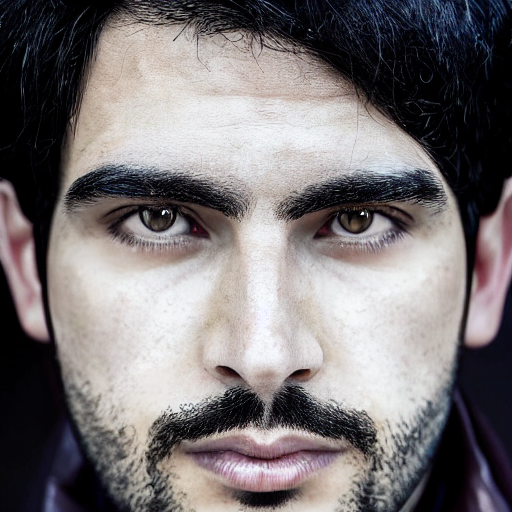

In [21]:

import torch

# Define the device variable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe=pipe.to(device)
condition="man with black hair"
image=pipe(condition).images[0]
image.save("man.png")
image